## Imports

In [17]:
import math
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
import os
import pandas as pd
import pickle
import requests
import seaborn as sns
import tarfile
import umap
import zipfile

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocessor
from keras.layers import Reshape
from keras.models import Model
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.stats import mode
from skimage.transform import resize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle as sk_shuffle
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Methods For Putting Cifar-10 Data Into Desirable Format

In [1]:
def download_and_extract(
        url='https://www.cs.toronto.edu/%7Ekriz/cifar-10-python.tar.gz',
        target_dir=None,
):
    """Download and extract CIFAR-10"""
    target_dir = target_dir or os.getcwd()

    filename = url.split('/')[-1]
    r = requests.get(url, stream=True)

    # total size in bytes
    total_size = int(r.headers.get('content-length', 0))
    block_size = 1024

    with open(filename, 'wb') as file_handle:
        for data in tqdm(
                r.iter_content(block_size),
                total=math.ceil(total_size // block_size),
                unit='KB',
                unit_scale=True
        ):
            file_handle.write(data)

    # extract if necessary
    if filename.endswith(".zip"):
        with zipfile.ZipFile(filename, "r") as zip_handle:
            zip_handle.extractall(target_dir)
            # since data was extracted, remove the zip file
            os.remove(filename)
    elif filename.endswith((".tar.gz", ".tgz")):
        with tarfile.open(filename, "r:gz") as tar_handle:
            tar_handle.extractall(target_dir)
            # since data was extracted, remove the tar file
            os.remove(filename)


def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')


def read_and_reshape_cifar10(data_dir='cifar-10-batches-py'):
    X, y = [], []

    for file in os.listdir(data_dir):
        if file.startswith('data') or file == 'test_batch':
            d = unpickle(os.path.join(data_dir, file))
            X.append(d[b'data'])
            y.append(d[b'labels'])

    X = np.concatenate(X)
    y = np.concatenate(y)

    X = np.transpose(X.reshape(-1, 3, 32, 32), axes=(0, 2, 3, 1))

    d = unpickle('cifar-10-batches-py/batches.meta')
    label_names = [x.decode('utf-8') for x in d[b'label_names']]

    return X, y, label_names


def resize_images(batch_data, target_size, preserve_range=True):
    resized_batch = np.array(
        [resize(batch_data[i], target_size, preserve_range=preserve_range)
         for i in range(batch_data.shape[0])]
    ).astype('float32')
    return resized_batch

## Gets Datset

In [3]:
download_and_extract()
X, y, label_names = read_and_reshape_cifar10()

167kKB [00:23, 7.08kKB/s]                           


In [35]:
cifar_vectors[0].shape

(2048,)

## Methods to Pull Vectors from Resnet-50

In [4]:
def data_generator(
    X, y, batch_size, target_size=(224, 224, 3), 
    preprocessor=resnet_preprocessor, shuffle=False):
    
    start = 0
    end = start + batch_size
    n = X.shape[0]
    if shuffle:
        X, y = sk_shuffle(X, y)
    while True:
        X_batch = X[start : end]
        y_batch = y [start : end]
        
        X_resized = resize_images(X_batch, target_size)
        X_preprocessed = preprocessor(X_resized)

        start += batch_size
        end   += batch_size
        if start >= n:
            start = 0
            end = batch_size
            if shuffle:
                X, y = sk_shuffle(X, y)
        yield (X_preprocessed, y_batch)

def resnet50_feature_extractor():
    model = ResNet50(weights='imagenet')
    layer_name = 'avg_pool'
    intermediate_layer_model = Model(
        inputs = model.input,
        outputs = model.get_layer(layer_name).output
        )
    return intermediate_layer_model

## Gets Vectors

In [5]:
resnet = resnet50_feature_extractor()

batch_size = 40
cifar_vectors = resnet.predict_generator(
    data_generator(
        X, y, batch_size=batch_size), 
        X.shape[0] / batch_size, verbose=1)

W1208 21:07:41.122882 4661810624 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1208 21:07:41.134061 4661810624 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1208 21:07:41.137683 4661810624 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1208 21:07:41.154759 4661810624 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session

1500/1500 [==============================] - 3682s 2s/step


## Perform KMeans and Get Accuracy

In [6]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(cifar_vectors)
y_predicted = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    y_predicted[mask] = mode(y[mask])[0]

accuracy_score(y, y_predicted)

0.5798333333333333

## Confusion Matrix

Text(76.2, 0.5, 'predicted label')

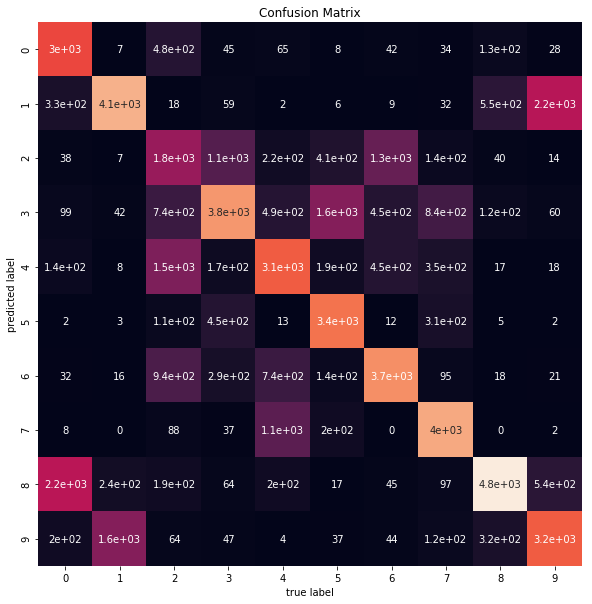

In [42]:
plt.figure(figsize=(10,10))
mat = confusion_matrix(y, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label')

## Compute PCA

In [25]:
pca_dim = PCA(n_components=2).fit_transform(cifar_vectors)

### Random State Needed For t-SNE and UMAP to work consistently

In [11]:
RS = 49457134

## Compute t-SNE
First use PCA for reduction, as computation on data of such size using t-SNE is computationally expensive.

In [32]:
pca_vectors_100 = PCA(n_components=100).fit_transform(cifar_vectors)
tsne_dim = TSNE(random_state=RS, verbose=1).fit_transform(pca_vectors_100)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.316s...
[t-SNE] Computed neighbors for 60000 samples in 801.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

## Compute UMAP

In [12]:
umap_dim = umap.UMAP(n_neighbors=30, random_state=RS).fit_transform(cifar_vectors)

## Scatter Plots

In [15]:
def scatter(vals, labels, num_classes, classes):
    """
    Scatters the dimensionality reduced vector representations of each
    image. Colors each class differently and places a black and white 
    label for the class at the center of it's cluster.

    :param vals: the x and y values to be scattered
    :param labels: the class labels for each xy value
    :param num_classes: the number of classes
    :param classes: the classes
    """
    palette = np.array(sns.color_palette("hls", num_classes))

    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vals[:,0], vals[:,1], lw=0, s=200,
                    c=palette[labels.astype(np.int)])
    for i in range(num_classes):
        xtxt, ytxt = np.median(vals[labels == i, :], axis=0)
        txt = ax.text(xtxt, ytxt, str(classes[i]), fontsize=25)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])

## PCA Plots

Text(0.5, 1.0, 'PCA: KMeans Labels')

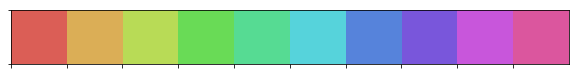

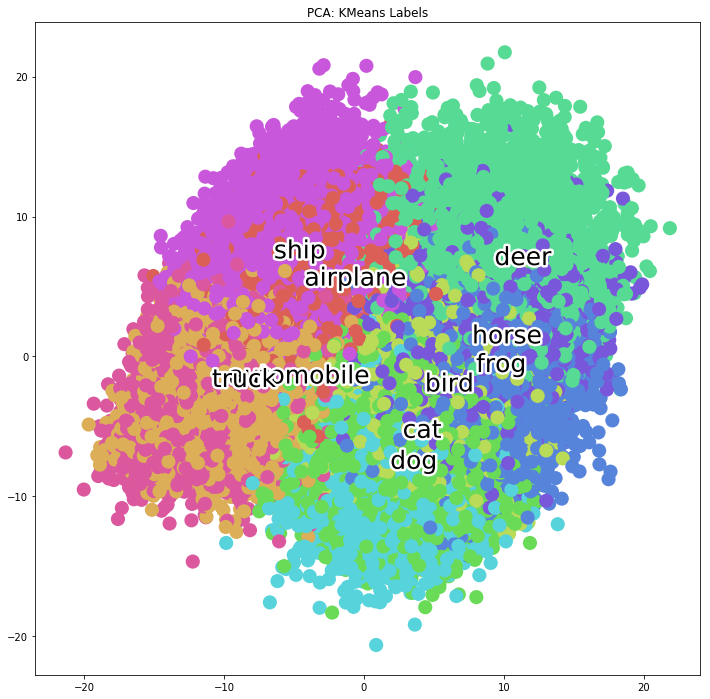

In [46]:
sns.palplot(np.array(sns.color_palette("hls", 10)))
scatter(pca_dim, y_predicted, 10, label_names)
plt.title('PCA: KMeans Labels')

Text(0.5, 1.0, 'PCA: Actual Labels')

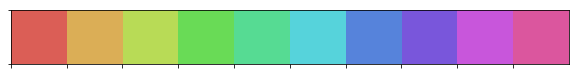

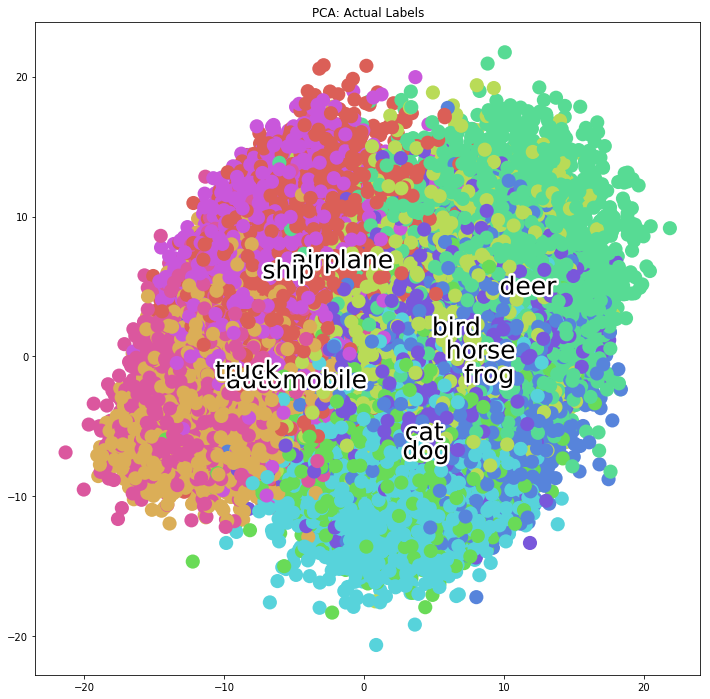

In [47]:
sns.palplot(np.array(sns.color_palette("hls", 10)))
scatter(pca_dim, y, 10, label_names)
plt.title('PCA: Actual Labels')

## TSNE Plots

Text(0.5, 1.0, 't-SNE: KMeans Labels')

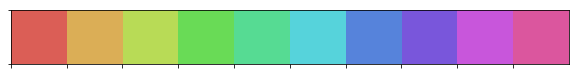

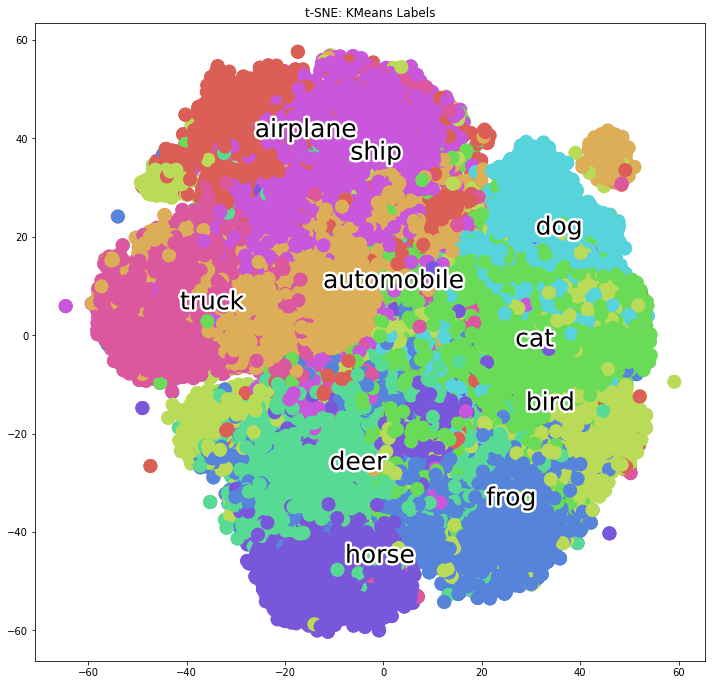

In [48]:
sns.palplot(np.array(sns.color_palette("hls", 10)))
scatter(tsne_dim, y_predicted, 10, label_names)
plt.title('t-SNE: KMeans Labels')

Text(0.5, 1.0, 't-SNE: Actual Labels')

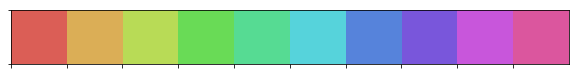

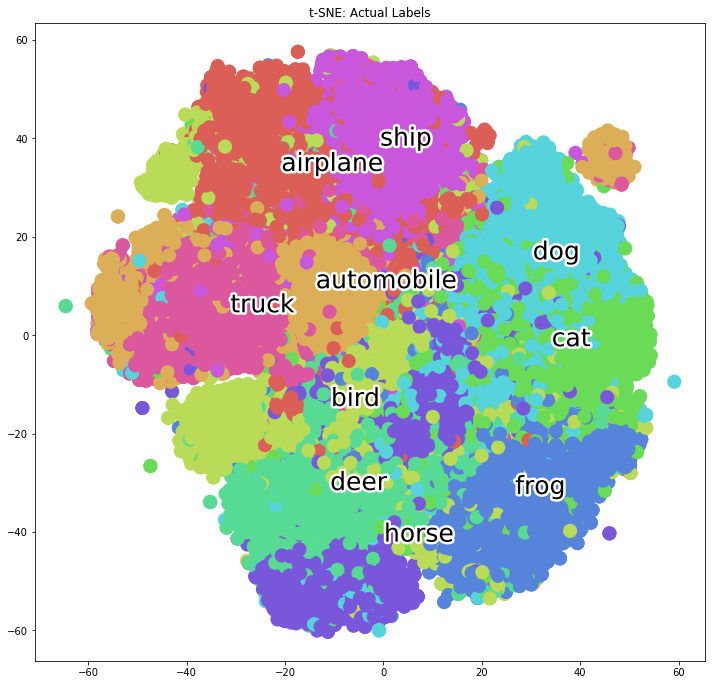

In [49]:
sns.palplot(np.array(sns.color_palette("hls", 10)))
scatter(tsne_dim, y, 10, label_names)
plt.title('t-SNE: Actual Labels')

## UMAP Plots

Text(0.5, 1.0, 'UMAP: KMeans Labels')

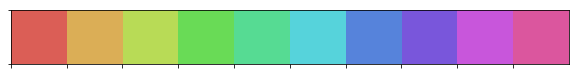

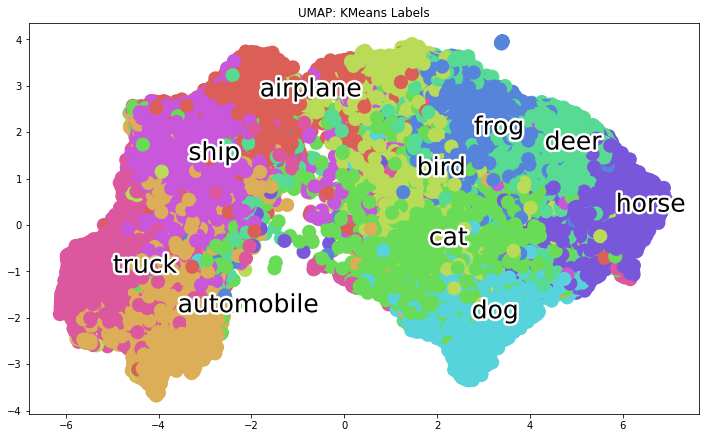

In [50]:
sns.palplot(np.array(sns.color_palette("hls", 10)))
scatter(umap_dim, y_predicted, 10, label_names)
plt.title('UMAP: KMeans Labels')

Text(0.5, 1.0, 'UMAP: Actual Labels')

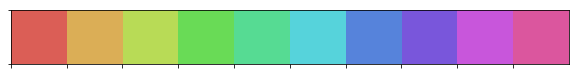

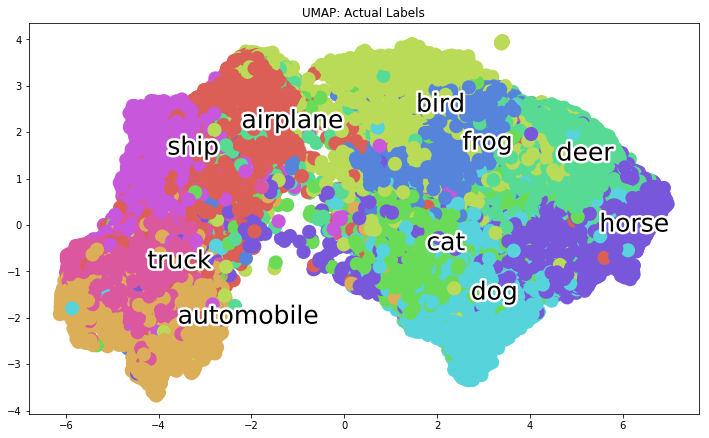

In [51]:
sns.palplot(np.array(sns.color_palette("hls", 10)))
scatter(umap_dim, y, 10, label_names)
plt.title('UMAP: Actual Labels')

## Reevaluated KMeans

In [41]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(pca_dim)
pca_predicted = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    pca_predicted[mask] = mode(y[mask])[0]

accuracy_score(y, pca_predicted)

0.3578

In [40]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(tsne_dim)
tsne_predicted = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    tsne_predicted[mask] = mode(y[mask])[0]

accuracy_score(y, tsne_predicted)

0.6081666666666666

In [39]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(umap_dim)
umap_predicted = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    umap_predicted[mask] = mode(y[mask])[0]

accuracy_score(y, umap_predicted)

0.69705